In [4]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Data
We downloaded the complete dataset. From the first few glimpses we notice that the dataset has quite an intricate structure. First of all we notice some features are very sparse. Also the features belong to different scales and are thus difficult to compare. Furthermore, there is a mix of continuous and categorical features. So first we adjust the categorical features to make the data tractable for the evaluating algorithms

In [42]:
data_original = pd.read_csv('kddcup.data')
data = data_original.drop('normal.', axis=1)

## Adjusting the Categorical Features
For each category of each categorical feature we create a column that indicates with a 1 if a datapoint belongs to that category and a 0 if it doesn't. Thus, we create a feature for each category.

In [43]:
def categorical_as_multicolumns(pd_data):
    for column_name in pd_data.columns:
        if pd_data[column_name].dtype.name == 'object':
            for category in np.unique(pd_data[column_name]):
                pd_data[column_name + '-' + category] = pd_data[column_name] == category
            pd_data.drop(column_name, axis=1, inplace=True)
    return pd_data       

## Normalizing the data
After adjusting for the categorical features, we normalize the data so that the magnitudes of each feature become more comparable. We do this by subtracting from each column its mean and then dividing it by its standard deviation. Thus, the scales of each feature have now comparable magnitudes. If this is the best choice for normalizing the data could be investigated further, as for example many features are very sparse.

Also we drop columns with zero variance, since they don't add further information.

In [44]:
def normalize(pd_data):
    for column in pd_data.columns:
        std = pd_data[column].std()
        if np.allclose(std, 0):
            print(f"For column {column} too low std detected: {std}\nDropping column")
            pd_data.drop(column, axis=1, inplace=True)
        else:
            pd_data[column] = (pd_data[column] - pd_data[column].mean())/pd_data[column].std()
    return pd_data

In [45]:
data = categorical_as_multicolumns(data)
data = normalize(data)

For column 0.13 too low std detected: 0.0
Dropping column


## Dimensionality Reduction
The larger the dimensionality of the data is, the more nuanced the differences in distance become between data points. Furthermore, dimensionality reduction helps with eliminating some of the noise and thus is beneficial for generalizing the data. Out of these reasons, and to shorten computation time we reduced the dimensionality of our data with SVD.

### How far to Reduce the Dimension?
To see how many prinicipal components are necessary to capture most of the signal, we look at the magnitudes of the eigenvalues of the correlation matrix. We work with a correlation matrix because we normalized the data to handle the different scales of the features.

In [266]:
# Use correlation instead of covariance matrix, since scales between features different
data_corr = 1/(data.shape[0]-1)*(data.values.T @ data.values)

In [267]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(data_corr)

True

The eigenvalues are sorted according to their magnitudes and then plotted. A heuristic tells us that the signal is captured by the eigenvalues with the biggest values. The values of these eigenvalues drop off usually very fast. The lower eigenvalues represent the noise in the data and usually have similarly large values. As a consequence, often times an elbow shaped plot of the eigenvalues can be seen, where the signal ends after the bend.

In our case the usage of the heuristic is a bit ambigous, as there are two stark elbow shaped drops to be observed. A large one for the first ten eigenvalues, and another one for the eigenvalues between the 80th and the 100th. We chose to cut off after the first bend and map our data onto the first 20 principal components, since the signal captured by these principal components seems sufficient and the number of reduced dimensions would be substantial. As a consequence our subsequent results possess the underlying assumption, that the clusters in the normalized data are to be found in a linear subspace that is spanned by the first 20 principal components.

However, it should be investigated further if not a different linear subspace would yield better results. Also if other dimensionality reduction techniques are suited better for the data as it exhibits high sparsity and maybe possesses less gaussianly distributed features. Since the class labels are provided one could maybe try out methods like LDA, that try to preserve class separability.

In [268]:
eigval = np.linalg.eigvalsh(data_corr)
eigval[::-1].sort()

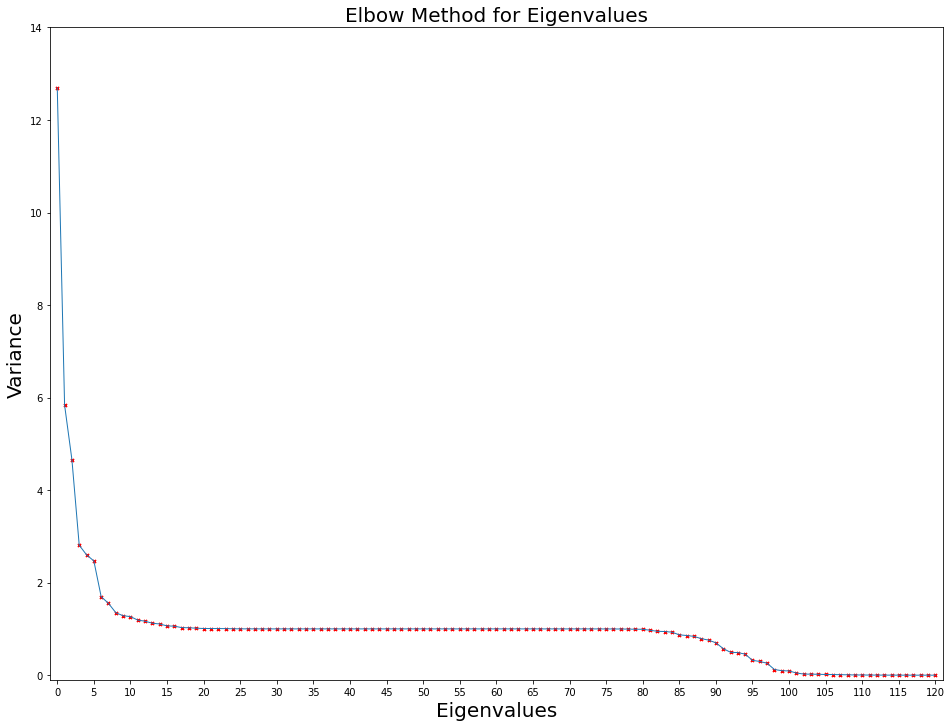

In [278]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,12))
lines = plt.plot(np.arange(len(eigval)), eigval, linewidth=1)
plt.scatter(np.arange(len(eigval)), eigval, s=10, c='r', marker='x')
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)
plt.title('Elbow Method for Eigenvalues', fontsize=20)
axes = plt.gca()
axes.set_xlim([-1,len(eigval)])
axes.set_ylim([-0.1, 14])
axes.set_xticks(np.arange(0,len(eigval),5))
plt.show()

# Clustering

After mapping the data onto a linear subspace, we run K-Means for several different values of $K$.

We use the K-Means implementation from the package Scikit-Learn.

## Initialization of the Clusters
To initialize the clusters we used an algorithm called **_"k-means++"_**, which is the default setting of the Scikit-Learn function. k-means++ provides a better spread of the initial centroids throughout the structure of the data, while preserving a sufficient amount of randomness. In summary: An inital centroid is chosen at random, and then a distribution is placed over data points according to the squared euclidean distance to the nearest centroid, in this case the initial centroid. From this distirbution a data point is chosen at random where the next cluster is placed. The remaining clusters are chosen in the same fashion.

## Number of Runs per $K$
K-Means converges to a local optimum, thus conducting multiple runs and picking the best is a good strategy. We kept the default parameter from the Scikit-Learn K-Means, which is 10 runs. Probably better results would be achieved for more runs, however time and computational resources are limited.

## Maximum Number of Iterations
Again we use the default paramter from Scikit-Learn, which is 300. A limit has to be set, since, due to things like rounding errors, convergence might not be met. Furthermore, one should expect a fast convergence with good initialization of the centroids. If the initialization was bad, then it might be better to move on to a new try.

## Optimization Criterion
Scikit-learn tries to minimize the inertia, which is the summed squared distance of each datapoint to its corresponding closest centroid. Convergence is declared if the inertia doesn't change from one run to the next by a value that is lower than a declared threshold.

## Metric
There are no options that we found in the Scikit-Learn implementation to declare a metric, therfore we assume that euclidean distances are used. The metric is inherently important to clustering algorithms, since it describes the similarity between points. The features of the dataset have all different scales, so one should consider to design a metric that more appropriately captures the similarity between data points. However, for this a more profound evaluation and prior knowledge are necessary, which could not be done given the limited time.

## Range of $K$
We chose to run the algorithm for values of $K$ from $\{1,\ldots,120\}$. It is quite likely that a higher value of $K$ might be a better choice, however time and computational resources are limited. In the end the choice of $K$ also depends on how fine grained one would like to have the analysis/model.

## Subsampling
Subsampling the data to achieve reduced computational time was not an option for us, since we couldn't fully exclude the possibility that the Data is not i.i.d. The outcome of a connection could have influenced the subsequent connections of that user and maybe even the connections of other users for it consumed network resources or even, in case of a malignent connection, damaged the network. A deeper analysis on how the data was gathered by the authors of the dataset would be necessary.

In [46]:
np.random.seed(0)
U, S, V = np.linalg.svd(data.values.T, full_matrices = False)

In [47]:
DIM_SUBSPACE = 20
pcs = U[:,:DIM_SUBSPACE] @ np.diag(S[:DIM_SUBSPACE])
pdata = data @ pcs

In [67]:
import os
if not os.path.isdir('./centroids'):
    os.mkdir('./centroids')

In [92]:
from sklearn.cluster import KMeans
from time import time

for k in range(1,2):
    print(f"Calculating centroids for K = {k}")
    t = time()
    kmeans = KMeans(k, random_state=0).fit(pdata)
    print(f"Completed after {np.round(time()-t, 2)}s\n")
    np.savetxt(f"./centroids/{k}", kmeans.cluster_centers_)

Calculating centroids for K = 1
Completed after 8.49s



# Evaluation

For a first evaluation we use another elbow heuristic applied on the **_"with-in cluster sum of squares"_**. For each value of $K$ we calculate the with-in cluster sum of squares, which is the summed squared distance of each datapoint to its respective centroid. This measures how much variance of the data is captured by the clusters. The more clusters, the less variance is captured by the individual clusters but rather "transferred" to the variance in-between the clusters. The idea is that once most of the variance of the data is distributed among the in-between cluster variance, then the clusters should be well spaced out in the data manifold and the remaining with-in cluster variance should correspond to minor dissimilarities between data points that therefore constitute a cluster.

The elbow shape occurs, since the larger dissimilarities in the data are captured rather quickly by a few clusters. The more clusters that are added thereafter, the less dissimilar they are to other clusters, thus points that are increasingly similar are split into new clusters. This could lead to the unwanted break up of a cluster. As a heuristic one should therefore choose the number of clusters where the benefit too fitting the dissimilarity structure of the data does not increase greatly with the addition of further clusters.

Looking at the plot one observes that it does not have a characteristic elbow shape, but is more a smooth curve. Picking which value of $K$ is the most appropriate is quite intricate. The curve strongly flattens from $10$ onwards, but one could also say from $50$ onwards, so maybe both of these would be a reasonable choice. The used heuristic assumes that the data within clusters resembles more some gaussian noise rather than further structure that could be interpreted as clusters, which is probably not the case for the data. Probably a hierarchical clustering approach is better suited for the data.

The method could probably be improved, by for example including the size of the clusters in the evaluation. Other existing techniques like the "gap statistic" intend to tweak and formalize this heuristic. We however, since the luxury of labels is provided, subsequently evaluate the models with regards to their capabilities of distinguishing between normal and malignent connections. In the end, a reasonable number of clusters is the amount that serves the task at hand well.

In [153]:
def wss(data, centroids):
    sum_wss = 0
    
    distances = np.linalg.norm(data.values[:,:,None]-centroids[None,:,:].transpose(0,2,1), axis=1)
        
    for i in range(centroids.shape[0]):
        sum_wss += np.power(distances[np.argmin(distances, axis=1)==i, i], 2).sum()
        
    return sum_wss

In [ ]:
collect_wss = np.empty((120,))

for k in range(1,121):
    centroids = np.loadtxt(f"./centroids/{k}")

    if k == 1:
        centroids = centroids[None,:]
    print(f"Calculating within sum-squares for K = {k}")
    t = time()
    collect_wss[k-1] = wss(pdata, centroids)
    print(f"Completed after {np.round(time()-t, 2)}s\nwss: {collect_wss[k-1]}\n")


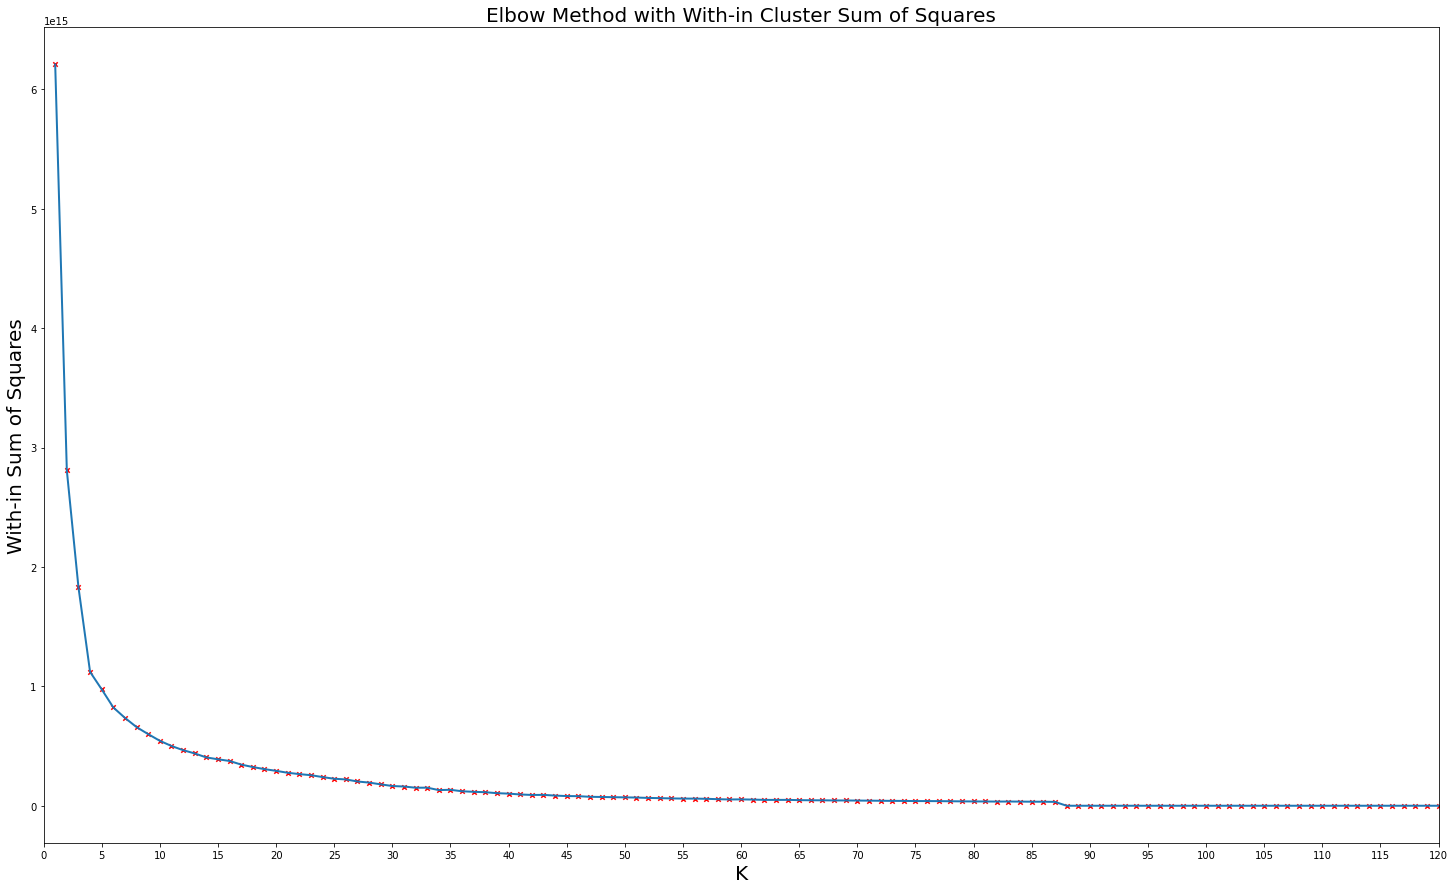

In [277]:
plt.figure(figsize=(25,15))
lines = plt.plot(np.arange(len(collect_wss))+1, collect_wss, linewidth=2)
plt.scatter(np.arange(len(collect_wss))+1, collect_wss, s=20, c='r', marker='x')
plt.xlabel('K', fontsize=20)
plt.ylabel('With-in Sum of Squares', fontsize=20)
plt.title('Elbow Method with With-in Cluster Sum of Squares', fontsize=20)
axes = plt.gca()
axes.set_xlim([0,len(collect_wss)])
axes.set_xticks(np.arange(0,len(collect_wss)+1,5))
plt.show()

## Leveraging the Labels
For each value of $K$ we consider two criteria. We consider subsequently all the malignent connections as positive samples.

### Cluster Purity
We calculate the entropy of each cluster and then weight it by its size. The entropy for a cluster $c_i$ is calculated as $-(p^i_+\log p^i_+ + p^i_-\log p^i_-)$, where $p^i_+$ denotes the probability of a malignent connection belonging to cluster $c_i$ and $p^i_-$ that of normal a one. Entropy is a concept from information theory and measures the certainty one can predict a particular outcome. High entropy corresponds to high uncertainty, thus we desire low entropy to have a more certain prediction for our a clusters. For a Bernoulli process the binary entropy function increases rapidly for small increases in uncertainty, as a consequence it is a good evaluation for cluster purity of binary variables.

### F1 Score
For intrusion detection systems it is important to detect malignent actions aswell to minimize false positives.

**Precision:** Measures how accurate the prediction of the model is if it predicts a malignent connection. Thus, increasing the precision should reduce false positives. $\frac{TP}{TP + FP}$

**Recall:** Measures how much of the malignent connections are detected. Therefore, increasing the recall should result in a good detection rate of malignent connections. $\frac{TP}{TP + FN}$

The F1 score combines precision and recall $2\frac{Precision \cdot Recall}{Precision + Recall}$. By optimizing the F1 score one should receive a good compromise between detecting malignent connections and reducing false positives.

In [196]:
def statistics(data, centroids):
    
    entropy = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    distances = np.linalg.norm(data.values[:,:,None]-centroids[None,:,:].transpose(0,2,1), axis=1)
    
    for i in range(centroids.shape[0]):
        
        cluster = np.argmin(distances, axis=1)==i
        
        normal = data_original['normal.'].values[cluster] == 'normal.'
        
        normal_sum = normal.sum()
        
        p_normal = normal_sum/normal.shape[0]
        p_unnormal = (normal.shape[0] - normal_sum)/normal.shape[0]
        
        # Calculate the entropy
        if p_normal == 0 or p_unnormal == 0:
            pass
        else:
            entropy += -(normal.shape[0]/data.shape[0])*(p_normal * np.log(p_normal) + p_unnormal * np.log(p_unnormal))
        
        # Calculate TP, FP, TN, FN
        if p_normal >= p_unnormal:
            TN += normal_sum
            FN += normal.shape[0]-normal_sum
        else:
            TP += normal.shape[0]-normal_sum
            FP += normal_sum
            
        
    return [entropy, TP, FP, TN, FN]

In [2]:
stats = pd.DataFrame(index=np.arange(120), columns=['K', 'weighted-entropy', 'TP', 'FP', 'TN', 'FN'])

for k in range(1,2):
    centroids = np.loadtxt(f"./centroids/{k}")
    print(pdata.shape, centroids.shape)
    if k == 1:
        centroids = centroids[None,:]
    print(f"Calculating weighted cluster entropies for K = {k}")
    t = time()
    statistics(pdata, centroids)
    stats.iloc[k-1] = [k] + statistics(pdata, centroids)
    print(f"Completed after {np.round(time()-t, 2)}s\nweighted entropies: {statistics['weighted-entropy'][k-1]}\n")

stats.to_csv('./centroids/statistics.csv')

# The Choice of $K$

## Entropy Plot
We normalized the weighted entropy to lie between $[0,1]$. Looking at the plot one obsereves that great cluster purity is achieved from $11$ clusters onwards. After that it steadily decreases further with small steps, so values above $11$ would also be reasonable.

In [5]:
stats = pd.read_csv('./centroids/statistics.csv')

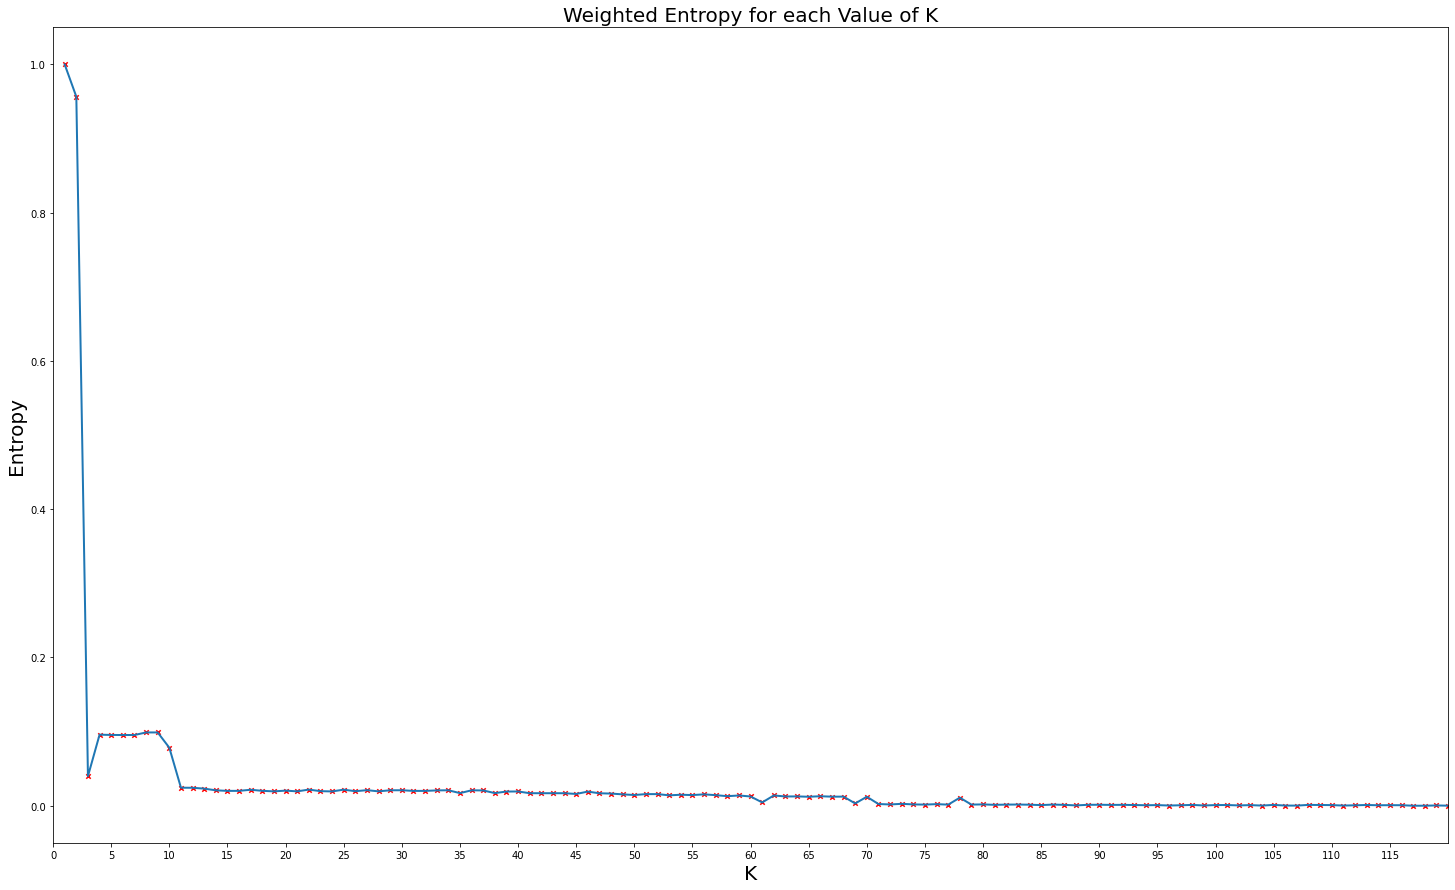

In [7]:
entropy = stats['weighted-entropy']
entropy = (entropy - entropy.min()) / (entropy.max()-entropy.min())

plt.figure(figsize=(25,15))
lines = plt.plot(stats['K'], entropy, linewidth=2)
plt.scatter(stats['K'], entropy, s=20, c='r', marker='x')
plt.xlabel('K', fontsize=20)
plt.ylabel('Entropy', fontsize=20)
plt.title('Weighted Entropy for each Value of K', fontsize=20)
axes = plt.gca()
axes.set_xlim([0,120])
axes.set_xticks(np.arange(0,120,5))
plt.show()

## F1 Plot
The F1 score seems to exhibit a strong inverse correlation with the entropy. Also at $K=11$ a high F1-score is achieved, and improves steadily in small steps thereafter.

In [14]:
def precision(TP, FP):
    return TP / (TP + FP)

def recall(TP, FN):
    return TP /(TP + FN)

def F1(precision, recall):
    return 2*precision*recall/(precision + recall)

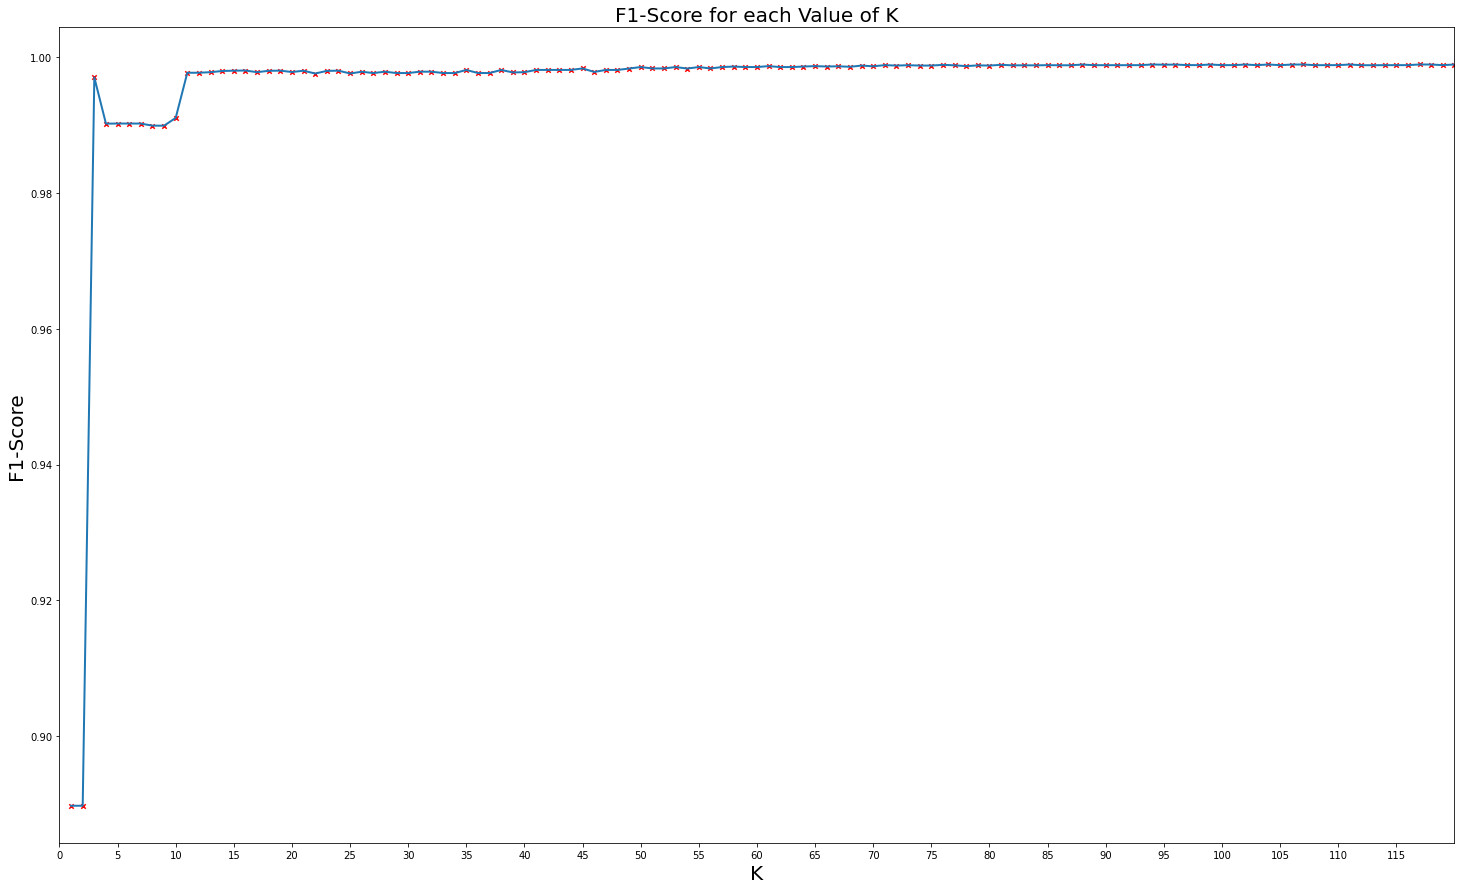

In [281]:
F1_scores = F1(precision(stats['TP'].values, stats['FP'].values), recall(stats['TP'].values, stats['FN'].values))

plt.figure(figsize=(25,15))
lines = plt.plot(stats['K'], F1_scores, linewidth=2)
plt.scatter(stats['K'], F1_scores, s=20, c='r', marker='x')
plt.xlabel('K', fontsize=20)
plt.ylabel('F1-Score', fontsize=20)
plt.title('F1-Score for each Value of K', fontsize=20)
axes = plt.gca()
axes.set_xlim([0,120])
axes.set_xticks(np.arange(0,120,5))
plt.show()

If we look at the lowest calculated values for entropy and F1-score they are both located at $K=116$, which is a interesting confluence and therefore supports its choice.

In [252]:
print(f'Minimum entropy: K={entropy.argmin()}\nMaximum F1: K={F1_scores.argmax()}')

Minimum entropy: K=116
Maximum F1: K=116


## Conclusion
The right choice of $K$ very much depends on what task is to be solved.

In machine learning usually the paradigm "to choose the model with the lowest complexity if performance is similar" is often upheld, as it would be assumed that the simpler model generalizes better. For this reason and not knowing the clustering purpose, we would pick $K=11$.

If an air tight intrusion detection system is to be built, then $K=116$ would work very well.

If a more fine grained analysis is to be conducted then a even higher value of $K$ could work better. Especially if the different malignent connections are to be distinguished, which we did not include in our evaluation.

# Further Evaluation
To anlyse the quality of the clustering further we investigate the clusters with regard to the individual classes of the malignent connections. We notice that the data set is very imbalanced, thus the detection of less prevalent classes could only be possible with threshhold methods, where these classes would have to be distinct enough to be outliers or with a much greater amount of clusters.

In [10]:
clust_data = pd.read_csv('cluster_labels/train_cluster_labeled')
clust_data['normal.'].value_counts()

smurf.              2807886
neptune.            1072017
normal.              972780
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: normal., dtype: int64

## F1-score per Class
Looking at the F1-score per class when solely relying on the clusters for classification, we see a correlation between class prevalance in the data set and its respective F1-score, thus the more prevalent classes have dominated the clustering.

In [16]:
def f1_cat(stats, cat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i, row in stats.iterrows():
        if cat.name == row.idxmax(axis=1):
            TP += cat[i]
            FP += row.sum() - cat[i]
        elif not np.isnan(cat[i]):
            FN += cat[i]
            TN += row.sum() - cat[i]
    
    if TP == 0:
        return 0
    else:
        return F1(precision(TP, FP), recall(TP, FN))

In [26]:
occ11 = clust_data.groupby('K11-closest')['normal.'].value_counts().unstack()
occ116 = clust_data.groupby('K116-closest')['normal.'].value_counts().unstack()
K11 = occ11.apply(lambda x: f1_cat(occ11, x))
K116 = occ116.apply(lambda x: f1_cat(occ116, x))
pd.concat([K11, K116], axis=1).rename(columns={0: 'K11', 1: 'K116'})

,K11,K116
normal.,,
back.,0.000000,0.000000
buffer_overflow.,0.000000,0.000000
ftp_write.,0.000000,0.000000
guess_passwd.,0.000000,0.803279
imap.,0.000000,0.000000
ipsweep.,0.783340,0.909310
land.,0.000000,0.857143
loadmodule.,0.000000,0.000000
multihop.,0.000000,0.000000


From the F1-score per class we infer that the less prevalent classes do not even cluster together in small clusters otherwise they would have some score above $0$. The cluster sizes vary much for $K=11$ aswell for $K=116$, nonetheless even small cluster seem to be made up of datapoints from prevalent classes.

In [35]:
clust_data['K11-closest'].value_counts()

1     2811284
0      869014
2      615584
4      280794
5      144308
7       96938
3       59337
10      17003
6        4093
9          74
8           1
Name: K11-closest, dtype: int64

In [36]:
clust_data['K116-closest'].value_counts()

0      2805539
104     417656
1       402049
2       206070
20      168734
        ...   
34           1
7            1
86           1
93           1
72           1
Name: K116-closest, Length: 116, dtype: int64

In [39]:
clust_data.loc[clust_data['K11-closest'] == 8,:]['normal.']

1401651    normal.
Name: normal., dtype: object

In [37]:
clust_data.loc[clust_data['K116-closest'] == 72,:]['normal.']

1446937    normal.
Name: normal., dtype: object

Thus, we conclude that k-means clustering alone does not seem to capture the desired of underlying structure of the individual classes. Next we investigate if possibilities exist to improve distinguishibility by splitting individual clusters.

## Analysis with the Local Outlier Factor
The Local Outlier Factor Algorithm is used to determine whether a point in a cluster is an outlier or not. This is achieved by computing the average density of the cluster and comparing it to the considered point. Thus, a factor, the local outlier factor, is assigned to the point representing the degree of being an outlier.

Our goal was to use the LOF to determine which points in a cluster are outliers and check if those are normal data or attack data.

For both, $K=11$ and $K=116$ we noticed that the larger the cluster is, the more inequal is the amount of calculated outliers and the amount of anomalies. Only for smaller clusters (< 15000 points) the detection could be used to differentiate between anomalies and normal data. But to use the LOF, a high purity of the cluster is necessary. If the cluster is a mixture of normal and anomaly data, the outlier factor didn't correlate with the type of data. But choosing $K=116$, we achieved a much higher purity of the clusters. Only 10 out of 116 clusters had an amount of anomalies between 10% and 90%, for an amount between 25% and 75% there were only 4 clusters.
Therefore, using $K=116$ should be preferred if possible due to more purity of the clusters.
The Local Outlier Factor itself seems not to be a good evaluation method in general.

In [ ]:
#be careful on execution, might take very long
scaler = StandardScaler()
for i in range(0, 116):
    dataset = pd.read_csv('data116/' + str(i) + '.csv')
    dataset_new = scaler.fit_transform(dataset)

    clf = LocalOutlierFactor(n_neighbors=20, metric= 'euclidean', algorithm='ball_tree')
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(dataset_new)
    
    print("Found outliers in " + str(i) + ": "+ str(len(dataset_new[np.where(y_pred == -1)])))

## Analysis using thresholds
The next method we used to evaluate our clusters are thresholds.
As we expected, using thresholds is not a good metric to evaluate whether a point is an anomaly or not, at least not for K=166
In the clusters containing mostly normal data, the anomalies or also inside the cluster and most of the time not on the outer regions, but spilled quite in the center area. But an another advantage of K=116 we faced is, that the clusters are also quite pure concercing the sort of attack data. So every cluster represents mostly one special kind of attack (e.g. SATAN, DDoS etc.). Only sometimes the attack sorts are equally mixed, if both attack vectors use similar vulnerabilites/tactics, e.g. SATAN and portsweep, as SATAN uses portsweep.
So K=116 is quite good at clustering attacks together, so it's useful to determine which kind of attack a point is if it is in a certain cluster. The disadvantage is, that there are still attack points inside of the normal cluster which can't be detected using thresholds.

The advantage of K=11 is the opposite. It is very bad in clustering normal and attack data in separate clusters, but good if it comes to using thresholds to detect attack data. Nevertheless, these thresholds need to be calculated for each cluster explicitly, so there is no rule or formula a good threshold can be set, since the distribution of attack data in the clusters is very different. But once a suitable threshold is calculated, it is performing quite well in separating normal and attack data. Nevertheless, K=11 can't be used to determine of which kind of attack an attack point is. Also, in practice, using static thresholds is not realistic, since new clusters can occur or the shape of clusters can change if the use of a service etc is changing.

# With Regards to the Test Data
Since the test data is not labeled, which is a bit strange, we test the stability of the clustering with regard to the test data.

In [50]:
test_data = pd.read_csv('kddcup.testdata.unlabeled')
test_data = categorical_as_multicolumns(test_data)
test_data = normalize(test_data)
test_pdata = test_data @ pcs

For column 0.14 too low std detected: 0.0
Dropping column


## Cluster stability
We run kmeans again with the cluster centers of the previous data as initial centroids.
Then we apply a heuristic to estimate how much the new centers deviate:
We look how many new cluster centroids are further away from the closest previous cluster centroid than the mean distance of the points in the previous cluster to the centroid.

More than two-thirds for $K=11$ and $K=116$ are further away, thus a low generalization can be assumed (under the assumption train and test data are representative)

In [52]:
from sklearn.cluster import KMeans
centroids11 = np.loadtxt(f"./centroids/{11}")
kmeans11 = KMeans(11, init=centroids11, n_init=1, random_state=0).fit(test_pdata)
((clust_data.groupby('K11-closest')['K11-distance'].mean() - np.linalg.norm((kmeans11.cluster_centers_ - centroids11[:,None,:]), axis=2).min(axis=0)) < 0).sum()

8

In [54]:
centroids116 = np.loadtxt(f"./centroids/{116}")
kmeans116 = KMeans(116, init=centroids116, n_init=1, random_state=0).fit(test_pdata)
((clust_data.groupby('K116-closest')['K116-distance'].mean() - np.linalg.norm((kmeans116.cluster_centers_ - centroids116[:,None,:]), axis=2).min(axis=0)) < 0).sum()

96

# Conclusion of the Evaluation
Our chosen clustering with K-Means is very successful in discerning between normal and malignant connections, however structure beyond that is not picked up. Further classification of the malignant connections is only to some degree possible, even with the help of thresholding or local outlier factor. One reason could be the high class imbalance of the dataset, the great similarity of some classes (the dataset should maybe be augmented with more features), aswell as probably the limitations of kmeans. Maybe a hierarchical clustering or EM-clustering or even a completely differen unsupervised learning method might prove more successful, however the data set seems very challenging.